# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

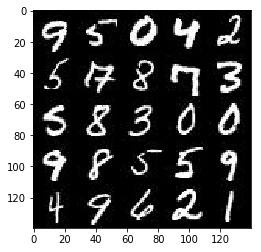

In [2]:
import numpy as np
import glob

show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

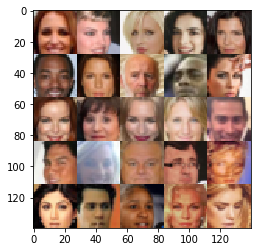

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    keep_prob = 0.9
    
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # img size 28*28*3
        x1 = tf.layers.conv2d(images, 32, 5, strides=1, padding="same")
        L_relu1 = tf.maximum(alpha*x1, x1)
        drop1 = tf.nn.dropout(L_relu1, keep_prob=keep_prob)
        
        # img size 28*28*32
        x2 = tf.layers.conv2d(drop1, 64, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        L_relu2 = tf.maximum(alpha*bn2, bn2)
        drop2 = tf.nn.dropout(L_relu2, keep_prob=keep_prob)
        
        # img size 14*14*64
        x3 = tf.layers.conv2d(drop2, 128, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        L_relu3 = tf.maximum(alpha*bn3, bn3)
        drop3 = tf.nn.dropout(L_relu3, keep_prob=keep_prob)
        
        # img size 7*7*128
        x4 = tf.layers.conv2d(drop3, 256, 5, strides=1, padding="same")
        bn4 = tf.layers.batch_normalization(x4, training=True)
        L_relu4 = tf.maximum(alpha*bn4, bn4)  
        drop4 = tf.nn.dropout(L_relu4, keep_prob=keep_prob)
        
        # img size 7*7*256
        flattened = tf.reshape(drop4, (-1, 7*7*256))
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)
        
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    reuse = not is_train
    alpha = 0.3
    keep_prob = 0.9
    
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse = reuse):
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        L_relu1 = tf.maximum(alpha * bn1, bn1)
        drop1 = tf.nn.dropout(L_relu1, keep_prob=keep_prob)

        # img size is 7*7*512
        x2 = tf.layers.conv2d_transpose(drop1, 256, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        L_relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(L_relu2, keep_prob=keep_prob)
        
        # img size is 14*14*256
        x3 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=1, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        L_relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(L_relu3, keep_prob=keep_prob)
        
        # img size is 14*14*128
        x4 = tf.layers.conv2d_transpose(drop3, 64, 5, strides=2, padding="same")
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        L_relu4 = tf.maximum(alpha * bn4, bn4)
        drop4 = tf.nn.dropout(L_relu4, keep_prob=keep_prob)
        
        # img size is 28*28*64
        logits = tf.layers.conv2d_transpose(drop4, out_channel_dim, 5, strides=1, padding="same")
        # img size is 28*28*out_channel_dim
        
        output = tf.tanh(logits)
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_out = generator(input_z, out_channel_dim, is_train=True)
    
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True)    
    
    # discriminator loss
    real_labels = tf.ones_like(d_real_logits) * (1 - smooth)
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=real_labels, logits=d_real_logits))
    
    fake_labels = tf.zeros_like(d_fake_logits) * (1 - smooth)
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=fake_labels, logits=d_fake_logits))
    
    d_loss = real_loss + fake_loss
    
    # generator loss
    g_labels = tf.ones_like(d_fake_logits)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=g_labels, logits=d_fake_logits)) 
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    '''
    # TODO: Implement Function
    ####################################################################################
    ########### why this implementation gets errors in test function ###################
    ####################################################################################
    with tf.trainable_variables(scope="discriminator"):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss)                    
    
    with tf.trainable_variables(scope="generator"):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss)                    
    '''            
    
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in trainable_vars if var.name.startswith("generator")]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)                    
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    step = 0            
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # load the model
        saver.restore(sess, './model.ckpt')
        print("\n loading the model .... ")    
        
        for epoch_i in range(epoch_count):                        
            for batch_images in get_batches(batch_size):
                # TODO: Train Model                                
                batch_images = batch_images * 2
                
                z_batch = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: z_batch, 
                                                 lr: learning_rate})
                sess.run(g_train_opt, feed_dict={z_input: z_batch, lr: learning_rate})
                
                train_d_loss = d_loss.eval({real_input: batch_images, z_input: z_batch})
                train_g_loss = g_loss.eval({z_input: z_batch})
                
                if(step % 10 == 0):
                    print("Epoch {}/{} ... " .format(epoch_i+1, epoch_count),
                          "Discriminator loss = {:4f}" .format(train_d_loss),
                          "Generator loss = {:4f}" .format(train_g_loss))
                                        
                    
                if(step % 100 == 0):
                    show_generator_output(sess, 25, z_input, data_shape[-1], data_image_mode)
                    # save the model
                    saver.save(sess, './model.ckpt')                      
                    
                step += 1                            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/8 ...  Discriminator loss = 2.964302 Generator loss = 0.576390


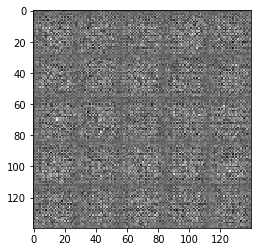

Epoch 1/8 ...  Discriminator loss = 1.433350 Generator loss = 0.874334
Epoch 1/8 ...  Discriminator loss = 1.222788 Generator loss = 1.459920


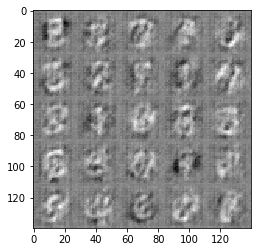

Epoch 1/8 ...  Discriminator loss = 1.017999 Generator loss = 0.953009
Epoch 1/8 ...  Discriminator loss = 1.128075 Generator loss = 1.021007


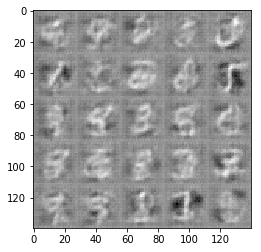

Epoch 1/8 ...  Discriminator loss = 1.434409 Generator loss = 0.631583
Epoch 1/8 ...  Discriminator loss = 1.117899 Generator loss = 1.377300


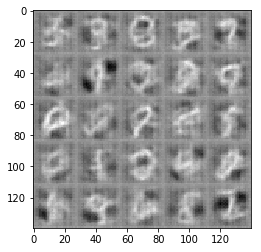

Epoch 1/8 ...  Discriminator loss = 1.004762 Generator loss = 1.265968
Epoch 1/8 ...  Discriminator loss = 0.924451 Generator loss = 1.196753


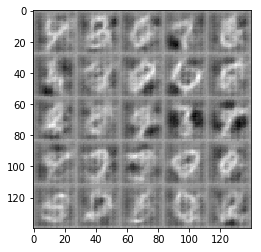

Epoch 1/8 ...  Discriminator loss = 0.940981 Generator loss = 1.305449
Epoch 2/8 ...  Discriminator loss = 1.339103 Generator loss = 0.686673


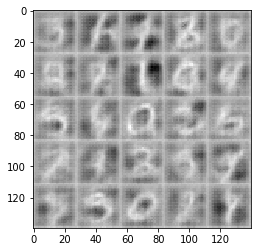

Epoch 2/8 ...  Discriminator loss = 1.190574 Generator loss = 0.800833
Epoch 2/8 ...  Discriminator loss = 0.951705 Generator loss = 1.137536


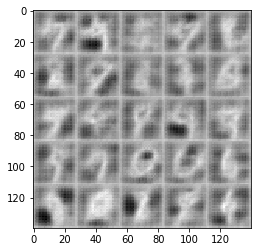

Epoch 2/8 ...  Discriminator loss = 0.818923 Generator loss = 1.336545
Epoch 2/8 ...  Discriminator loss = 0.908971 Generator loss = 1.157556


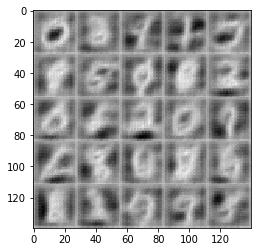

Epoch 2/8 ...  Discriminator loss = 0.890400 Generator loss = 1.232228
Epoch 2/8 ...  Discriminator loss = 0.914743 Generator loss = 1.533412


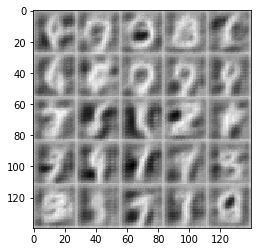

Epoch 2/8 ...  Discriminator loss = 1.198340 Generator loss = 0.804991
Epoch 2/8 ...  Discriminator loss = 1.002280 Generator loss = 0.979128


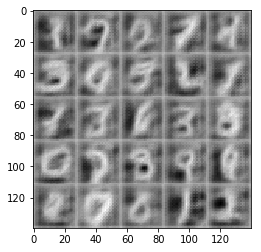

Epoch 3/8 ...  Discriminator loss = 0.914997 Generator loss = 1.184768
Epoch 3/8 ...  Discriminator loss = 0.941039 Generator loss = 1.066865


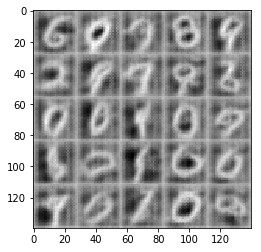

Epoch 3/8 ...  Discriminator loss = 0.828347 Generator loss = 1.357403
Epoch 3/8 ...  Discriminator loss = 1.193797 Generator loss = 0.800554


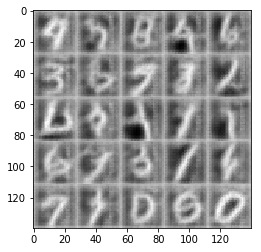

Epoch 3/8 ...  Discriminator loss = 1.094962 Generator loss = 2.348514
Epoch 3/8 ...  Discriminator loss = 1.653222 Generator loss = 0.717582


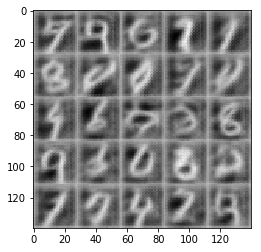

Epoch 3/8 ...  Discriminator loss = 0.943775 Generator loss = 1.032491
Epoch 3/8 ...  Discriminator loss = 1.649762 Generator loss = 0.737630


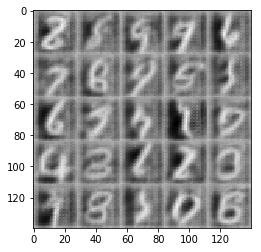

Epoch 3/8 ...  Discriminator loss = 0.932900 Generator loss = 1.400872
Epoch 3/8 ...  Discriminator loss = 1.258024 Generator loss = 0.879549


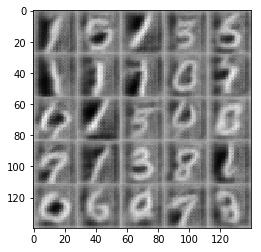

Epoch 4/8 ...  Discriminator loss = 0.883371 Generator loss = 1.166359
Epoch 4/8 ...  Discriminator loss = 1.145267 Generator loss = 0.853961


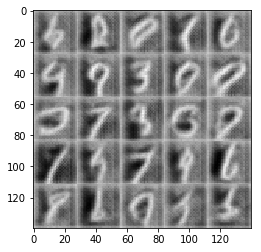

Epoch 4/8 ...  Discriminator loss = 0.872923 Generator loss = 1.221807
Epoch 4/8 ...  Discriminator loss = 0.804940 Generator loss = 1.330893


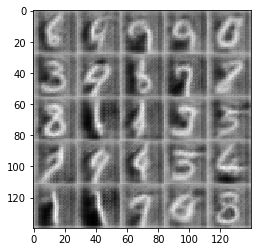

Epoch 4/8 ...  Discriminator loss = 0.930950 Generator loss = 1.070008
Epoch 4/8 ...  Discriminator loss = 0.815594 Generator loss = 1.294927


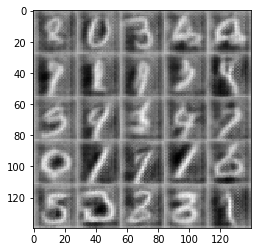

Epoch 4/8 ...  Discriminator loss = 0.620880 Generator loss = 2.134531
Epoch 4/8 ...  Discriminator loss = 0.785941 Generator loss = 1.329042


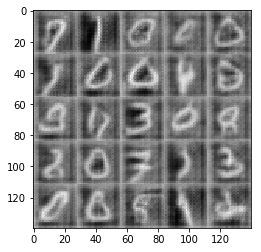

Epoch 4/8 ...  Discriminator loss = 0.864903 Generator loss = 1.545254
Epoch 5/8 ...  Discriminator loss = 0.843825 Generator loss = 2.215136


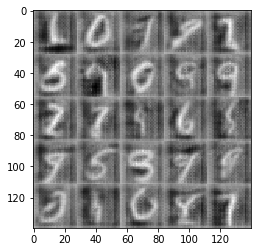

Epoch 5/8 ...  Discriminator loss = 0.740161 Generator loss = 1.576575
Epoch 5/8 ...  Discriminator loss = 0.879987 Generator loss = 1.188942


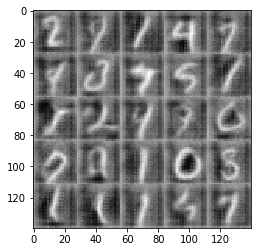

Epoch 5/8 ...  Discriminator loss = 0.880103 Generator loss = 1.724143
Epoch 5/8 ...  Discriminator loss = 0.802912 Generator loss = 1.508013


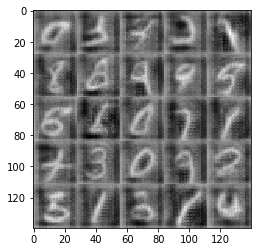

Epoch 5/8 ...  Discriminator loss = 0.800051 Generator loss = 1.353315
Epoch 5/8 ...  Discriminator loss = 0.698732 Generator loss = 1.840393


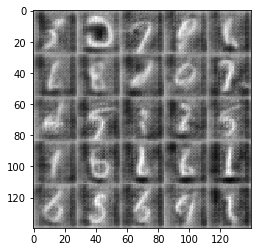

Epoch 5/8 ...  Discriminator loss = 0.785917 Generator loss = 1.566780
Epoch 5/8 ...  Discriminator loss = 0.798307 Generator loss = 1.338867


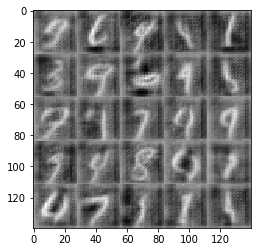

Epoch 6/8 ...  Discriminator loss = 0.752172 Generator loss = 1.900805
Epoch 6/8 ...  Discriminator loss = 1.094226 Generator loss = 0.881029


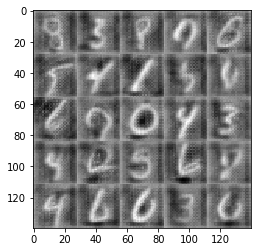

Epoch 6/8 ...  Discriminator loss = 0.882645 Generator loss = 1.454823
Epoch 6/8 ...  Discriminator loss = 0.862864 Generator loss = 1.284901


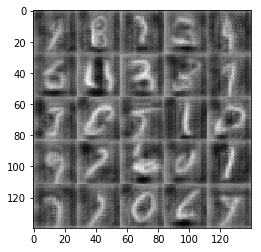

Epoch 6/8 ...  Discriminator loss = 0.879335 Generator loss = 1.211848
Epoch 6/8 ...  Discriminator loss = 0.806643 Generator loss = 1.375226


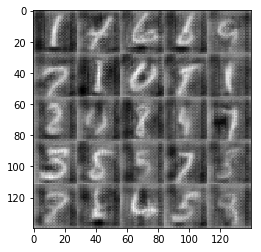

Epoch 6/8 ...  Discriminator loss = 1.055068 Generator loss = 2.121463
Epoch 6/8 ...  Discriminator loss = 0.948106 Generator loss = 1.052883


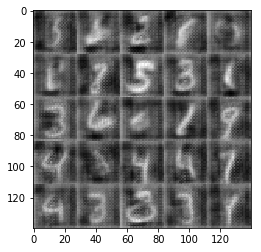

Epoch 6/8 ...  Discriminator loss = 0.676365 Generator loss = 2.017957
Epoch 6/8 ...  Discriminator loss = 0.864139 Generator loss = 1.206039


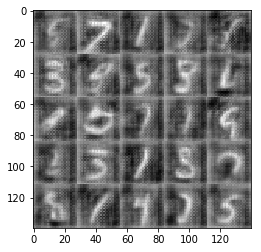

Epoch 7/8 ...  Discriminator loss = 0.864044 Generator loss = 1.434343
Epoch 7/8 ...  Discriminator loss = 1.043844 Generator loss = 0.978688


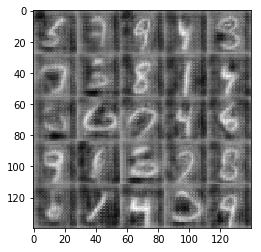

Epoch 7/8 ...  Discriminator loss = 0.819051 Generator loss = 1.896144
Epoch 7/8 ...  Discriminator loss = 1.005436 Generator loss = 1.019446


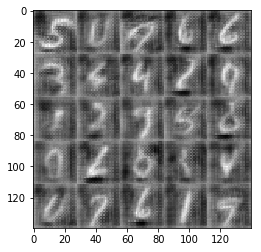

Epoch 7/8 ...  Discriminator loss = 0.968201 Generator loss = 1.069131
Epoch 7/8 ...  Discriminator loss = 0.861884 Generator loss = 1.229581


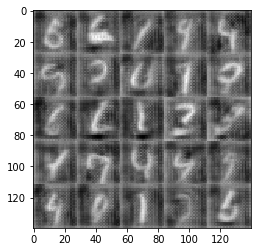

Epoch 7/8 ...  Discriminator loss = 2.843018 Generator loss = 5.082327
Epoch 7/8 ...  Discriminator loss = 0.965600 Generator loss = 1.009901


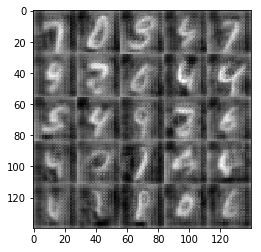

Epoch 7/8 ...  Discriminator loss = 1.300176 Generator loss = 0.764024
Epoch 8/8 ...  Discriminator loss = 0.791116 Generator loss = 1.651459


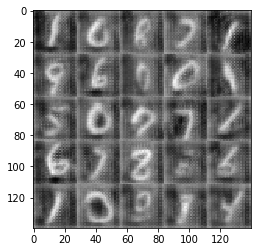

Epoch 8/8 ...  Discriminator loss = 0.748082 Generator loss = 2.020232
Epoch 8/8 ...  Discriminator loss = 0.990122 Generator loss = 0.982965


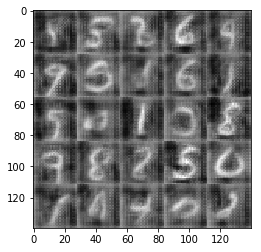

Epoch 8/8 ...  Discriminator loss = 0.657033 Generator loss = 1.865130
Epoch 8/8 ...  Discriminator loss = 1.395806 Generator loss = 0.696561


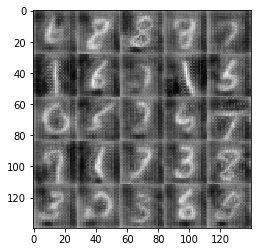

Epoch 8/8 ...  Discriminator loss = 0.767476 Generator loss = 1.537250
Epoch 8/8 ...  Discriminator loss = 0.895608 Generator loss = 1.371088


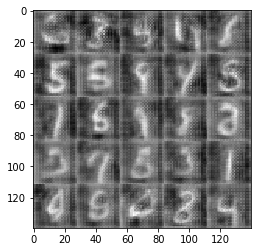

Epoch 8/8 ...  Discriminator loss = 0.950702 Generator loss = 1.543467
Epoch 8/8 ...  Discriminator loss = 0.761687 Generator loss = 1.723496


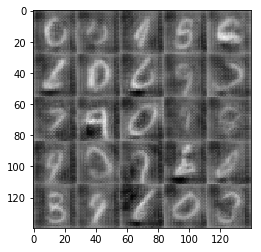

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 8

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

INFO:tensorflow:Restoring parameters from ./model.ckpt

 loading the model .... 
Epoch 1/5 ...  Discriminator loss = 0.665146 Generator loss = 3.487616


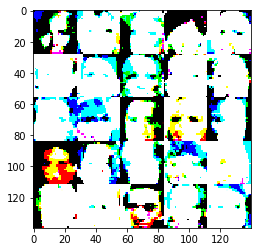

Epoch 1/5 ...  Discriminator loss = 1.179365 Generator loss = 0.905717
Epoch 1/5 ...  Discriminator loss = 1.324264 Generator loss = 1.084018
Epoch 1/5 ...  Discriminator loss = 1.176538 Generator loss = 1.452517
Epoch 1/5 ...  Discriminator loss = 1.124974 Generator loss = 0.951622
Epoch 1/5 ...  Discriminator loss = 1.031415 Generator loss = 1.061787
Epoch 1/5 ...  Discriminator loss = 0.906552 Generator loss = 1.970050
Epoch 1/5 ...  Discriminator loss = 0.901366 Generator loss = 1.811265
Epoch 1/5 ...  Discriminator loss = 1.001721 Generator loss = 0.941956
Epoch 1/5 ...  Discriminator loss = 0.579903 Generator loss = 2.335062
Epoch 1/5 ...  Discriminator loss = 0.491127 Generator loss = 2.600989


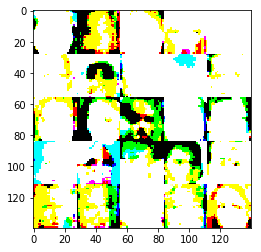

Epoch 1/5 ...  Discriminator loss = 0.795765 Generator loss = 1.287601
Epoch 1/5 ...  Discriminator loss = 0.588125 Generator loss = 2.795870
Epoch 1/5 ...  Discriminator loss = 0.447412 Generator loss = 3.296830
Epoch 1/5 ...  Discriminator loss = 0.573830 Generator loss = 2.456751
Epoch 1/5 ...  Discriminator loss = 1.342768 Generator loss = 1.076282
Epoch 1/5 ...  Discriminator loss = 0.551705 Generator loss = 2.122512
Epoch 1/5 ...  Discriminator loss = 0.565390 Generator loss = 3.214646
Epoch 1/5 ...  Discriminator loss = 0.467861 Generator loss = 2.464579
Epoch 1/5 ...  Discriminator loss = 0.534382 Generator loss = 4.158473
Epoch 1/5 ...  Discriminator loss = 0.441710 Generator loss = 2.909689


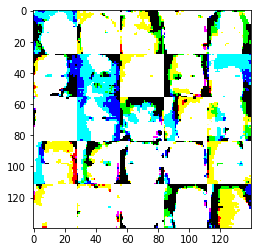

Epoch 1/5 ...  Discriminator loss = 0.390533 Generator loss = 3.768203
Epoch 1/5 ...  Discriminator loss = 0.438304 Generator loss = 4.198168
Epoch 1/5 ...  Discriminator loss = 0.348928 Generator loss = 5.920427
Epoch 1/5 ...  Discriminator loss = 0.513380 Generator loss = 2.538724
Epoch 1/5 ...  Discriminator loss = 0.457885 Generator loss = 2.611492
Epoch 1/5 ...  Discriminator loss = 0.960190 Generator loss = 1.272269
Epoch 1/5 ...  Discriminator loss = 0.626488 Generator loss = 2.105727
Epoch 1/5 ...  Discriminator loss = 0.552522 Generator loss = 2.291295
Epoch 1/5 ...  Discriminator loss = 0.946025 Generator loss = 1.269271
Epoch 1/5 ...  Discriminator loss = 0.485477 Generator loss = 2.667648


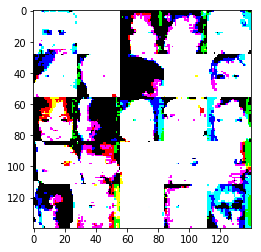

Epoch 1/5 ...  Discriminator loss = 0.496038 Generator loss = 3.232090
Epoch 1/5 ...  Discriminator loss = 1.730873 Generator loss = 3.484939
Epoch 1/5 ...  Discriminator loss = 0.617860 Generator loss = 1.754285
Epoch 1/5 ...  Discriminator loss = 0.998822 Generator loss = 2.355313
Epoch 1/5 ...  Discriminator loss = 0.530829 Generator loss = 2.656301
Epoch 1/5 ...  Discriminator loss = 0.372804 Generator loss = 4.393148
Epoch 1/5 ...  Discriminator loss = 0.477140 Generator loss = 3.313460
Epoch 1/5 ...  Discriminator loss = 0.511438 Generator loss = 2.183450
Epoch 1/5 ...  Discriminator loss = 0.870570 Generator loss = 6.207507
Epoch 1/5 ...  Discriminator loss = 0.357193 Generator loss = 5.861006


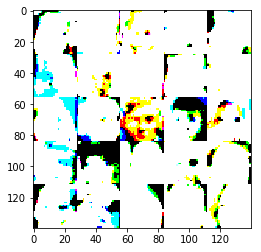

Epoch 1/5 ...  Discriminator loss = 0.371701 Generator loss = 4.791385
Epoch 1/5 ...  Discriminator loss = 0.394747 Generator loss = 2.566031
Epoch 1/5 ...  Discriminator loss = 0.396256 Generator loss = 3.580166
Epoch 1/5 ...  Discriminator loss = 0.717172 Generator loss = 3.990343
Epoch 1/5 ...  Discriminator loss = 0.488131 Generator loss = 3.939987
Epoch 1/5 ...  Discriminator loss = 0.371082 Generator loss = 4.606356
Epoch 1/5 ...  Discriminator loss = 0.668148 Generator loss = 9.430866
Epoch 1/5 ...  Discriminator loss = 0.457774 Generator loss = 5.573147
Epoch 1/5 ...  Discriminator loss = 0.375047 Generator loss = 4.045156
Epoch 1/5 ...  Discriminator loss = 0.435935 Generator loss = 3.497948


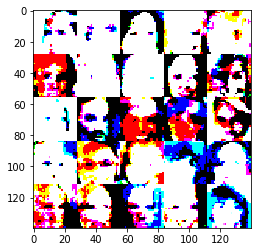

Epoch 1/5 ...  Discriminator loss = 0.406832 Generator loss = 6.285688
Epoch 1/5 ...  Discriminator loss = 0.970112 Generator loss = 1.089306
Epoch 1/5 ...  Discriminator loss = 0.665411 Generator loss = 2.863720
Epoch 1/5 ...  Discriminator loss = 0.481686 Generator loss = 2.473506
Epoch 1/5 ...  Discriminator loss = 0.405507 Generator loss = 4.469711
Epoch 1/5 ...  Discriminator loss = 0.369188 Generator loss = 4.493728
Epoch 1/5 ...  Discriminator loss = 0.386721 Generator loss = 3.639062
Epoch 1/5 ...  Discriminator loss = 0.561585 Generator loss = 2.883231
Epoch 1/5 ...  Discriminator loss = 0.363925 Generator loss = 6.071426
Epoch 1/5 ...  Discriminator loss = 0.410342 Generator loss = 4.463630


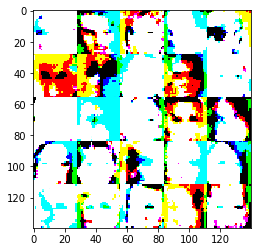

Epoch 1/5 ...  Discriminator loss = 0.363436 Generator loss = 5.973248
Epoch 1/5 ...  Discriminator loss = 0.363383 Generator loss = 4.761415
Epoch 1/5 ...  Discriminator loss = 0.364576 Generator loss = 5.938948
Epoch 1/5 ...  Discriminator loss = 0.386792 Generator loss = 4.769407
Epoch 1/5 ...  Discriminator loss = 0.387561 Generator loss = 4.372099
Epoch 1/5 ...  Discriminator loss = 0.409344 Generator loss = 4.217951
Epoch 1/5 ...  Discriminator loss = 0.422000 Generator loss = 3.103834
Epoch 1/5 ...  Discriminator loss = 0.380256 Generator loss = 7.417138
Epoch 1/5 ...  Discriminator loss = 0.367988 Generator loss = 4.568038
Epoch 1/5 ...  Discriminator loss = 0.371939 Generator loss = 4.479208


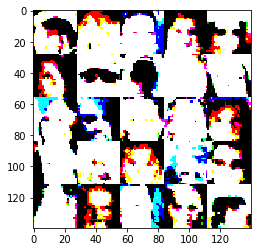

Epoch 1/5 ...  Discriminator loss = 0.362765 Generator loss = 5.996930
Epoch 1/5 ...  Discriminator loss = 0.360273 Generator loss = 5.435180
Epoch 1/5 ...  Discriminator loss = 0.395839 Generator loss = 5.170842
Epoch 1/5 ...  Discriminator loss = 0.482396 Generator loss = 2.896838
Epoch 1/5 ...  Discriminator loss = 0.366648 Generator loss = 9.468712
Epoch 1/5 ...  Discriminator loss = 0.381314 Generator loss = 3.713934
Epoch 1/5 ...  Discriminator loss = 0.492159 Generator loss = 4.138724
Epoch 1/5 ...  Discriminator loss = 1.183945 Generator loss = 8.029963
Epoch 1/5 ...  Discriminator loss = 0.404287 Generator loss = 4.700317
Epoch 1/5 ...  Discriminator loss = 0.370588 Generator loss = 4.326829


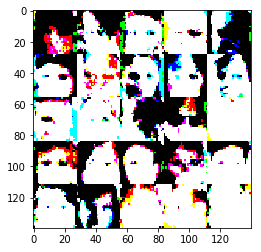

Epoch 1/5 ...  Discriminator loss = 0.502252 Generator loss = 2.970482
Epoch 1/5 ...  Discriminator loss = 0.380627 Generator loss = 5.158692
Epoch 1/5 ...  Discriminator loss = 0.395447 Generator loss = 4.749022
Epoch 1/5 ...  Discriminator loss = 0.352516 Generator loss = 5.889252
Epoch 1/5 ...  Discriminator loss = 0.353254 Generator loss = 6.411952
Epoch 1/5 ...  Discriminator loss = 0.354647 Generator loss = 6.396047
Epoch 1/5 ...  Discriminator loss = 0.379856 Generator loss = 4.759350
Epoch 1/5 ...  Discriminator loss = 0.383264 Generator loss = 4.937427
Epoch 1/5 ...  Discriminator loss = 0.353701 Generator loss = 6.122934
Epoch 1/5 ...  Discriminator loss = 3.755467 Generator loss = 8.243842


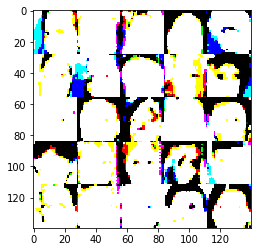

Epoch 1/5 ...  Discriminator loss = 0.623667 Generator loss = 2.767525
Epoch 1/5 ...  Discriminator loss = 0.748721 Generator loss = 4.319929
Epoch 1/5 ...  Discriminator loss = 0.509591 Generator loss = 2.908320
Epoch 1/5 ...  Discriminator loss = 0.677503 Generator loss = 1.773899
Epoch 1/5 ...  Discriminator loss = 0.521691 Generator loss = 2.581816
Epoch 1/5 ...  Discriminator loss = 0.435653 Generator loss = 3.803783
Epoch 1/5 ...  Discriminator loss = 0.460371 Generator loss = 4.227143
Epoch 1/5 ...  Discriminator loss = 0.365670 Generator loss = 5.255775
Epoch 1/5 ...  Discriminator loss = 0.395464 Generator loss = 5.584226
Epoch 1/5 ...  Discriminator loss = 0.432190 Generator loss = 2.786073


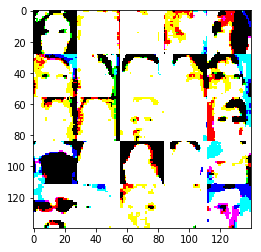

Epoch 1/5 ...  Discriminator loss = 0.409695 Generator loss = 4.201178
Epoch 1/5 ...  Discriminator loss = 0.423780 Generator loss = 4.389492
Epoch 1/5 ...  Discriminator loss = 0.388695 Generator loss = 6.190002
Epoch 1/5 ...  Discriminator loss = 0.356247 Generator loss = 7.052038
Epoch 1/5 ...  Discriminator loss = 0.444394 Generator loss = 4.167777
Epoch 1/5 ...  Discriminator loss = 0.601111 Generator loss = 4.973172
Epoch 1/5 ...  Discriminator loss = 0.381376 Generator loss = 3.377776
Epoch 1/5 ...  Discriminator loss = 0.357027 Generator loss = 6.026777
Epoch 1/5 ...  Discriminator loss = 0.358314 Generator loss = 4.792003
Epoch 1/5 ...  Discriminator loss = 0.603800 Generator loss = 3.068538


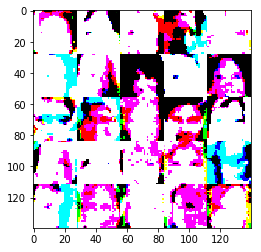

Epoch 1/5 ...  Discriminator loss = 0.356650 Generator loss = 7.675478
Epoch 1/5 ...  Discriminator loss = 0.397984 Generator loss = 6.928746
Epoch 1/5 ...  Discriminator loss = 1.723572 Generator loss = 0.697576
Epoch 1/5 ...  Discriminator loss = 0.441946 Generator loss = 3.156863
Epoch 1/5 ...  Discriminator loss = 0.431429 Generator loss = 2.899446
Epoch 1/5 ...  Discriminator loss = 0.364592 Generator loss = 6.309626
Epoch 1/5 ...  Discriminator loss = 0.378987 Generator loss = 4.312414
Epoch 1/5 ...  Discriminator loss = 0.378193 Generator loss = 5.527668
Epoch 1/5 ...  Discriminator loss = 0.392106 Generator loss = 3.374736


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.